In [1]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shap
from joblib import dump
from joblib import load
import seaborn as sns

In [2]:
data = pd.read_csv('player_data_1_year_back.csv')

In [3]:
def per_game(row):
    return row[0]/row[1]

X = data[['Age', 'Player_Season_Num', 'prev_GP', 'prev_G',
       'prev_A', 'prev_PTS', 'prev_S', 'career_GP', 'career_G',
       'career_A', 'career_PTS', 'career_S', 'games', 'total_goals_per_game',
       'goals_pp', 'chances_pp', 'shots', 'shot_pct']]
y_init = data[['PTS','GP',]]

y_init['PTS/GP'] = y_init.apply(per_game,axis=1)

y = y_init['PTS/GP']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
xg_reg_wrap = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.1,
                max_depth = 100, n_estimators = 100)

In [7]:
xg_reg_wrap.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=100, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [99]:
preds = xg_reg.predict(X)
y_pred = xg_reg.predict(X)
y_pred.shape

(24338,)

In [144]:
results_dict = {
    'player': data.Player,
    'PTS': y_init.PTS.values,
    'PTS_predict': np.round(pred*y_init.GP.values),
    'PTS_per_Game': y,
    'PTS_per_Game_predict': pred,
}

In [145]:
results_df = pd.DataFrame(results_dict)

In [152]:
results_df[results_df.player=='Brent Burns']

,player,PTS,PTS_predict,PTS_per_Game,PTS_per_Game_predict
2745,Brent Burns,16,19.0,0.222222,0.260270
2746,Brent Burns,25,23.0,0.324675,0.302944
2747,Brent Burns,43,29.0,0.524390,0.356677
2748,Brent Burns,27,32.0,0.457627,0.545355
2749,Brent Burns,20,24.0,0.425532,0.507692
2750,Brent Burns,46,34.0,0.575000,0.419571
2751,Brent Burns,37,46.0,0.456790,0.561984
2752,Brent Burns,20,14.0,0.666667,0.464088
2753,Brent Burns,48,40.0,0.695652,0.580324
2754,Brent Burns,60,52.0,0.731707,0.631434


In [105]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.9,'learning_rate': 0.1,
                'alpha': 1, 'max_depth': 100}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True)

In [28]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.9,'learning_rate': 0.1,
                'lambda': 1, 'max_depth': 100}

cv_results_hist = []
cv_results_len = []
best_val = 1e9
best_param = params.copy()
for colsample_bytree in np.linspace(0.1,1,10):
    for learning_rate in [0.01, 0.03, 0.1, 0.3, 1]:
        for max_depth in [3, 6, 10, 30, 50]:
            for l2 in [0, 0.1, 0.3, 1]:
                params['colsample_bytree'] = colsample_bytree
                params['learning_rate'] = learning_rate
                params['max_depth'] = max_depth
                params['lambda'] = l2
                
                cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                        num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True)
                
                cv_results_hist.append(cv_results["test-rmse-mean"].min())
                cv_results_len.append(len(cv_results))
                if cv_results["test-rmse-mean"].min() < best_val:
                    best_val = cv_results["test-rmse-mean"].min()
                    best_param = params.copy()
                    
                print_line = f'\rCS={colsample_bytree} ** lr={learning_rate} ** depth={max_depth} ** L2={l2}                  '
                print(print_line,end='')

xg_reg1 = xgb.train(params=best_param, dtrain=data_dmatrix, num_boost_round=50)

dump(xg_reg1, 'xgb_model1.dat')
dump(best_param, 'params_model1.dat')

CS=1.0 ** lr=1 ** depth=50 ** L2=1                                       

['params_model1.dat']

In [135]:
xg_reg = xgb.train(params=best_param, dtrain=data_dmatrix, num_boost_round=50)

In [141]:
pred = xg_reg.predict(data_dmatrix)

In [143]:
pred.shape

(24338,)

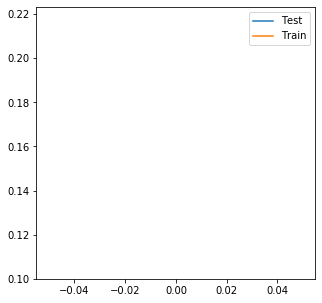

In [142]:
plt.plot(cv_results["test-rmse-mean"],label='Test')
plt.plot(cv_results["train-rmse-mean"],label='Train')
plt.legend()
plt.show()

In [11]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

NameError: name 'params' is not defined

ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

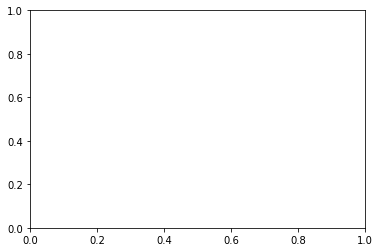

In [5]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

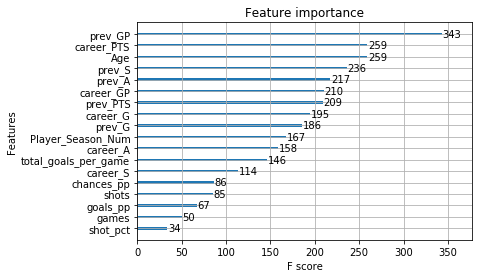

In [6]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [10]:
xg_reg.predict(X)

TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)

In [7]:
dump(xg_reg, "xgb_one_season.dat")

NameError: name 'xg_reg' is not defined

In [8]:
xg_reg = load("xgb_one_season.dat")

XGBoostError: [13:24:12] src/gbm/gbm.cc:20: Unknown gbm type 

In [8]:
shap.initjs()
explainer = shap.TreeExplainer(xg_reg_wrap)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [11]:
shap_values = explainer.shap_values(X_subset)

In [10]:
X_subset = shap.sample(X,1000)

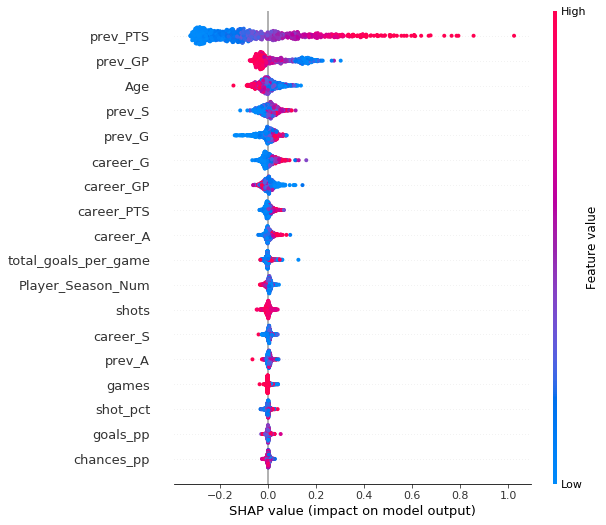

In [14]:
shap.summary_plot(shap_values, X_subset)#, plot_type="bar")

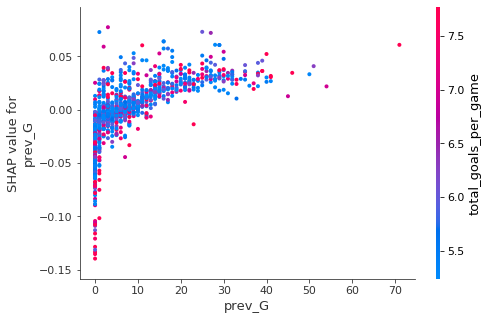

In [23]:
feature = 'prev_G'
shap.dependence_plot(feature, shap_values, X_subset, interaction_index='total_goals_per_game')

In [24]:
data2 = pd.read_csv('player_data_2_years_back.csv')
X2 = data2[['Age', 'Player_Season_Num', 'prev_GP', 'prev_G',
       'prev_A', 'prev_PTS', 'prev_S', 'career_GP', 'career_G',
       'career_A', 'career_PTS', 'career_S', 'games', 'total_goals_per_game',
       'goals_pp', 'chances_pp', 'shots', 'shot_pct']]
y2_init = data2[['PTS','GP',]]

y2_init['PTS/GP'] = y2_init.apply(per_game,axis=1)

y2 = y2_init['PTS/GP']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
data2_dmatrix = xgb.DMatrix(data=X2,label=y2)

In [29]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.9,'learning_rate': 0.1,
                'lambda': 1, 'max_depth': 100}

cv2_results_hist = []
cv2_results_len = []
best_val = 1e9
best_param2 = params.copy()
for colsample_bytree in np.linspace(0.1,1,10):
    for learning_rate in [0.01, 0.03, 0.1, 0.3, 1]:
        for max_depth in [3, 6, 10, 30, 50]:
            for l2 in [0, 0.1, 0.3, 1]:
                params['colsample_bytree'] = colsample_bytree
                params['learning_rate'] = learning_rate
                params['max_depth'] = max_depth
                params['lambda'] = l2
                
                cv_results = xgb.cv(dtrain=data2_dmatrix, params=params, nfold=5,
                        num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True)
                
                cv2_results_hist.append(cv_results["test-rmse-mean"].min())
                cv2_results_len.append(len(cv_results))
                if cv_results["test-rmse-mean"].min() < best_val:
                    best_val = cv_results["test-rmse-mean"].min()
                    best_param2 = params.copy()
                    
                print_line = f'\rCS={colsample_bytree} ** lr={learning_rate} ** depth={max_depth} ** L2={l2}                  '
                print(print_line,end='')

xg_reg2 = xgb.train(params=best_param2, dtrain=data2_dmatrix, num_boost_round=50)

dump(xg_reg2, 'xgb_model2.dat')
dump(best_param2, 'params_model2.dat')

CS=1.0 ** lr=1 ** depth=50 ** L2=1                                       

['params_model2.dat']

In [25]:
data3 = pd.read_csv('player_data_3_years_back.csv')
X3 = data3[['Age', 'Player_Season_Num', 'prev_GP', 'prev_G',
       'prev_A', 'prev_PTS', 'prev_S', 'career_GP', 'career_G',
       'career_A', 'career_PTS', 'career_S', 'games', 'total_goals_per_game',
       'goals_pp', 'chances_pp', 'shots', 'shot_pct']]
y3_init = data3[['PTS','GP',]]

y3_init['PTS/GP'] = y3_init.apply(per_game,axis=1)

y3 = y3_init['PTS/GP']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
data3_dmatrix = xgb.DMatrix(data=X3,label=y3)

In [30]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.9,'learning_rate': 0.1,
                'lambda': 1, 'max_depth': 100}

cv3_results_hist = []
cv3_results_len = []
best_val = 1e9
best_param3 = params.copy()
for colsample_bytree in np.linspace(0.1,1,10):
    for learning_rate in [0.01, 0.03, 0.1, 0.3, 1]:
        for max_depth in [3, 6, 10, 30, 50]:
            for l2 in [0, 0.1, 0.3, 1]:
                params['colsample_bytree'] = colsample_bytree
                params['learning_rate'] = learning_rate
                params['max_depth'] = max_depth
                params['lambda'] = l2
                
                cv_results = xgb.cv(dtrain=data3_dmatrix, params=params, nfold=5,
                        num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True)
                
                cv3_results_hist.append(cv_results["test-rmse-mean"].min())
                cv3_results_len.append(len(cv_results))
                if cv_results["test-rmse-mean"].min() < best_val:
                    best_val = cv_results["test-rmse-mean"].min()
                    best_param3 = params.copy()
                    
                print_line = f'\rCS={colsample_bytree} ** lr={learning_rate} ** depth={max_depth} ** L2={l2}                  '
                print(print_line,end='')

xg_reg3 = xgb.train(params=best_param3, dtrain=data3_dmatrix, num_boost_round=50)

dump(xg_reg3, 'xgb_model3.dat')
dump(best_param3, 'params_model3.dat')

CS=1.0 ** lr=1 ** depth=50 ** L2=1                                       

NameError: name 'xg_reg3' is not defined

In [31]:
xg_reg3 = xgb.train(params=best_param3, dtrain=data3_dmatrix, num_boost_round=50)

dump(xg_reg3, 'xgb_model3.dat')
dump(best_param3, 'params_model3.dat')

['params_model3.dat']

In [36]:
best_param3, best_param2, best_param

({'objective': 'reg:squarederror',
  'colsample_bytree': 0.6,
  'learning_rate': 0.1,
  'lambda': 0.3,
  'max_depth': 6},
 {'objective': 'reg:squarederror',
  'colsample_bytree': 0.8,
  'learning_rate': 0.1,
  'lambda': 0.3,
  'max_depth': 6},
 {'objective': 'reg:squarederror',
  'colsample_bytree': 0.7000000000000001,
  'learning_rate': 0.1,
  'lambda': 1,
  'max_depth': 6})

In [41]:
xg_reg2 = xgb.train(params=best_param2, dtrain=data2_dmatrix, num_boost_round=50)